In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
import matplotlib.pyplot as plt
import h5py
import skopt
from skopt.space import Real
from skopt.learning import GaussianProcessRegressor as GPR
from skopt.learning.gaussian_process.kernels import Matern, WhiteKernel, Product, ConstantKernel
%run ./Functions.ipynb
import matplotlib as mpl
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')

### Dataset generation

In [2]:
## intial point on the attractor
u0 = np.array([7.432487609628195, 10.02071718705213, 29.62297428638419])

dt        = 0.01
t_lyap    = 0.9**(-1)
N_lyap    = int(t_lyap/dt)  # number of time steps in one Lyapunov time

# number of time steps for washout, train, validation and PH window
N_washout = 1*N_lyap
N_train   = 8*N_lyap
N_val     = 3*N_lyap
N_tstart  = 24*N_lyap 
N_test    = 500*N_lyap

norm      = np.array([35.23020746, 45.09776766, 36.07598481])

# generate data 
U         = solve_ode(N_washout+N_train+N_val+N_test, dt, u0)
# washout
U_washout = U[:N_washout]
# training
U_t       = U[N_washout:N_washout+N_train-1]
Y_t       = U[N_washout+1:N_washout+N_train]
# training + validation
U_tv      = U[N_washout:N_washout+N_train+N_val-1]
Y_tv      = U[N_washout+1:N_washout+N_train+N_val]
# validation
Y_val     = U[N_washout+N_train:N_washout+N_train+N_val]

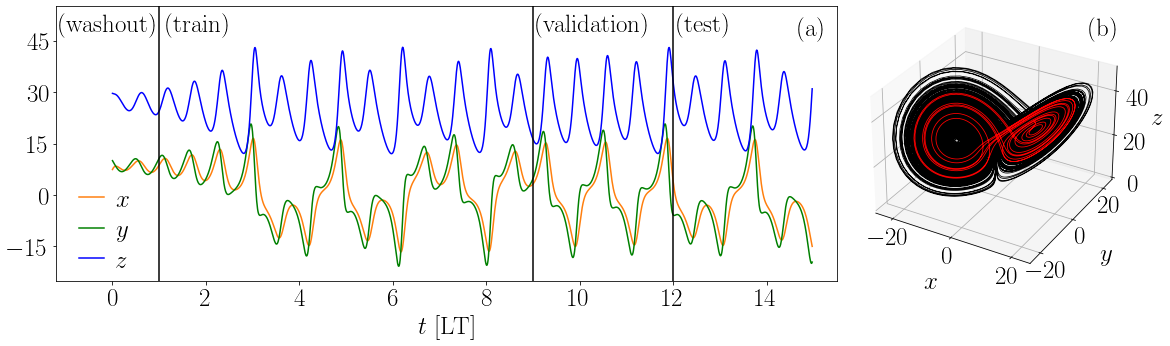

In [3]:
## Plot Dataset

t = np.arange(U.shape[0])*dt/t_lyap #define time in Lyapunov times

from matplotlib.gridspec import *
plt.rcParams["figure.figsize"] = (16,5)
plt.rcParams["font.size"] = 25
axx = plt.figure()

gs = GridSpec(1, 2, width_ratios=[2.8,1])

# phase plot
ax = axx.add_subplot(gs[1], projection='3d')
ax.annotate('(b)', xy=(1, 1), xytext=(-10, -10), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points')
ax.set_xlabel('$x$', labelpad=10)
ax.set_ylabel('$y$', labelpad=10)
ax.set_zlabel('$z$', labelpad=6)
ax.tick_params(axis='x', pad=-2)
ax.tick_params(axis='y', pad=-2)
ax.tick_params(axis='z', pad=5)
ax.set_xlim(-25,25)
ax.set_ylim(-25,25)
ax.set_zlim(0,50)
#entire attractor
ax.plot(U[0:324*N_lyap:,0], U[0:324*N_lyap:,1],
        U[0:324*N_lyap:,2], color='k', linewidth=0.8)
#our dataset
ax.plot(U[0:12*N_lyap:,0], U[0:12*N_lyap:,1],
        U[0:12*N_lyap:,2], color='r', linewidth=0.8)

#time series
ax = axx.add_subplot(gs[0])
ax.set_xlabel('$t$ [LT]')
lim    = 12*N_lyap
pl_lim = 15*N_lyap
ax.plot(t[:pl_lim],
         U[:pl_lim, 0], label='$x$', c='tab:orange')
ax.plot(t[:pl_lim],
         U[:pl_lim, 1], label='$y$', c='g')
ax.plot(t[:pl_lim],
         U[:pl_lim, 2], label='$z$', c='b')

ax.set_xlim(-1.2,15.5)
ax.set_ylim(-25.,55.)
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(15))

ax.axvline(1, c='k')
ax.axvline(9, c='k')
ax.axvline(12, c='k')

ax.annotate('(washout)', xy=(0, 1), xytext=(+3, -6), va='top', ha='left',
             xycoords='axes fraction', textcoords='offset points')
ax.annotate('(train)', xy=(0, 1), xytext=(+110, -6), va='top', ha='left',
             xycoords='axes fraction', textcoords='offset points')
ax.annotate('(validation)', xy=(1, 1), xytext=(-185, -6), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points')
ax.annotate('(test)', xy=(1, 1), xytext=(-105, -6), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points')
ax.annotate('(a)', xy=(1, 1), xytext=(-10, -10), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points')
ax.legend(labelspacing=.3, handletextpad=0.5, handlelength=1., loc='lower left',
         bbox_to_anchor=(0.0,-0.05), frameon=False)

gs.tight_layout(figure=axx,pad=.55)
plt.show()

### Import Results From  Optimization Runs

In [4]:
######## Load from Validation Runs

# Obtained by running Validation_Short_Lorenz.ipynb
# minimum is (size_ensemble, 3), for each network we have stored the optimal parameters and optimal MSE
# each h5 file is a different run of Validation_Short_Lorenz.ipynb 

#BO and Grid Search in SSV
hf       = h5py.File('./data/Lor_short_SSV_50_5.h5','r')
Min_25G  = np.array(hf.get('minimum'))
hf.close()

hf       = h5py.File('./data/Lor_short_SSV_50_7.h5','r')
Min_50G  = np.array(hf.get('minimum'))
hf.close()

# #BO and Grid Search in RVC 
hf       = h5py.File('./data/Lor_short_RVC_50_5.h5','r')
Min_25G_mmv  = np.array(hf.get('minimum'))
hf.close()

# hf       = h5py.File('./data/FrNp_8_3MSE_Bias_MMV_Log_50G_50_49_0.h5','r')
hf       = h5py.File('./data/Lor_short_RVC_50_7.h5','r')
Min_50G_mmv  = np.array(hf.get('minimum'))
hf.close()

# BO and Grid Search in WFV
hf       = h5py.File('./data/Lor_short_WFV_50_5.h5','r')
Min_25G_wfv  = np.array(hf.get('minimum'))
hf.close()

hf       = h5py.File('./data/Lor_short_WFV_50_7.h5','r')
Min_50G_wfv  = np.array(hf.get('minimum'))
hf.close()

#BO and Grid Search in KFV 
hf       = h5py.File('./data/Lor_short_KFV_50_5.h5','r')
Min_25G_kfv  = np.array(hf.get('minimum'))
hf.close()

hf       = h5py.File('./data/Lor_short_KFV_50_7.h5','r')
Min_50G_kfv  = np.array(hf.get('minimum'))
hf.close()

#BO and Grid Search in RV 
hf       = h5py.File('./data/Lor_short_RV_50_5.h5','r')
Min_25G_mv  = np.array(hf.get('minimum'))
hf.close()

hf       = h5py.File('./data/Lor_short_RV_50_7.h5','r')
Min_50G_mv  = np.array(hf.get('minimum'))
hf.close()

#BO and Grid Search in KFC
hf       = h5py.File('./data/Lor_short_KFC_50_5.h5','r')
Min_25G_kfo  = np.array(hf.get('minimum'))
hf.close()

hf       = h5py.File('./data/Lor_short_KFC_50_7.h5','r')
Min_50G_kfo  = np.array(hf.get('minimum'))
hf.close()

#BO and Grid Search WFC
hf       = h5py.File('./data/Lor_short_WFC_50_5.h5','r')
Min_25G_wfc  = np.array(hf.get('minimum'))
hf.close()

hf       = h5py.File('./data/Lor_short_WFC_50_7.h5','r')
Min_50G_wfc  = np.array(hf.get('minimum'))
hf.close()

########Load Test Results

#obtained from TestSet_Short_Lorenz.ipynb
#res are (size_ensemble, 2). For each network we have the MSE and PH in the test set for the optimal hyperparameters

fln = './data/Short_Lorenz_PostProc.h5'

hf          = h5py.File(fln,'r')
res_Gr      = np.array(hf.get('res_Gr     '))
res_BO      = np.array(hf.get('res_BO     '))
res_Gr_mmv  = np.array(hf.get('res_Gr_mmv '))
res_BO_mmv  = np.array(hf.get('res_BO_mmv '))
res_Gr_mv   = np.array(hf.get('res_Gr_mv  '))
res_BO_mv   = np.array(hf.get('res_BO_mv  '))
res_Gr_kfv  = np.array(hf.get('res_Gr_kfv '))
res_BO_kfv  = np.array(hf.get('res_BO_kfv '))
res_Gr_kfo  = np.array(hf.get('res_Gr_kfo '))
res_BO_kfo  = np.array(hf.get('res_BO_kfo '))
res_Gr_wfc  = np.array(hf.get('res_Gr_wfc '))
res_BO_wfc  = np.array(hf.get('res_BO_wfc '))
res_Gr_wfv  = np.array(hf.get('res_Gr_wfv '))
res_BO_wfv  = np.array(hf.get('res_BO_wfv '))

hf.close()

## SSV lack of Robustness 

Min and max values in validation and test
-6.762016297563177 -3.5799363492308327 -6.190443041594836 -1.644843414834198
Spearman coefficient
ssv 0.32584458445844583


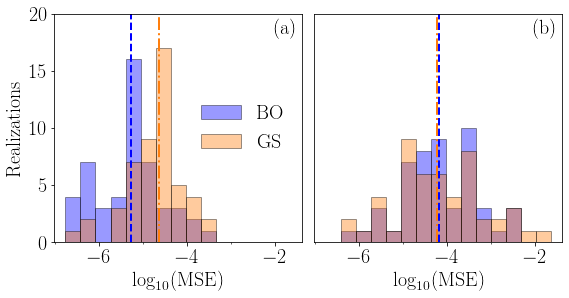

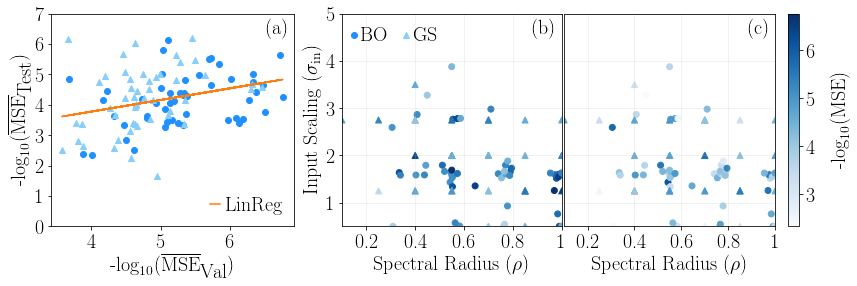

In [5]:
#Load the performance of the SSV in the 12 to 15 Lts interval computed in 
fln = './data/Short_Lorenz_PostProc2.h5'
hf = h5py.File(fln,'r')
res_Gr1      = np.array(hf.get('res_Gr1     '))
res_BO1      = np.array(hf.get('res_BO1     '))
hf.close()
# no more in log scale
Min_25G1     = Min_25G.copy()
Min_50G1     = Min_50G.copy()
Min_25G1[:,2]     = 10**Min_25G[:,2]
Min_50G1[:,2]     = 10**Min_50G[:,2]

from scipy.stats import linregress
from matplotlib.gridspec import *

import scipy

q1 = 0.25
q2 = 1 - q1

titles = ['-$\log_{10}(\overline{\\textrm{MSE}}_{\\textrm{Val}}$)',
              '-$\log_{10}(\overline{\\textrm{MSE}}_{\\textrm{Test}}$)']

bins=15

from matplotlib.gridspec import GridSpec
plt.rcParams["figure.figsize"] = (12,4)
plt.rcParams["font.size"] = 20

axx = plt.figure()
# plotting histogram performance in validation and signle inteerval test set for SSV
gs = GridSpec(1, 3, width_ratios=[1., 4., 1], figure=axx, wspace=0.05)
gs00 = GridSpecFromSubplotSpec(1, 2, width_ratios=[1., 1.], subplot_spec=gs[1], wspace=0.05)

x = np.log10(Min_25G1[:,2])
y = np.log10(Min_50G1[:,2])
amin = np.min(np.concatenate((x,y)))
amax = np.max(np.concatenate((x,y)))
x = np.log10(res_BO1[:,0])
y = np.log10(res_Gr1[:,0])
bmin = np.min(np.concatenate((x,y)))
bmax = np.max(np.concatenate((x,y)))

print('Min and max values in validation and test')
print(amin,amax,bmin,bmax)

bmax = np.concatenate((x,y))[np.argsort(np.concatenate((x,y)))][-1]

## Performance of the optimal hyperparameters in the validation set for Bayesian Optimization
 # and Grid Search
a0 = axx.add_subplot(gs00[0])
a0.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
a0.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))


plt.ylim(0.,20)
plt.ylabel('Realizations')
plt.xlabel('$\log_{10}$(MSE)')
plt.hist(np.log10(Min_25G1[:,2]), alpha=0.4, label='BO', color='b'
         , range=(amin,bmax), edgecolor='k', bins=bins)
plt.hist(np.log10(Min_50G1[:,2]), alpha=0.4, label='GS', color='tab:orange'
         , range=(amin,bmax), edgecolor='k', bins=bins)
plt.axvline(np.median(np.log10(Min_25G1[:,2])),color='b', ls='--', lw=2)
plt.axvline(np.median(np.log10(Min_50G1[:,2])),color='tab:orange', ls='-.', lw=2)
plt.annotate('(a)', xy=(1, 1), xytext=(-5, -5), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points')
plt.legend(loc='center right', frameon=False)

## Performance of the optimal hyperparameters in the interval from 12 to 15 for Bayesian Optimization
 # and Grid Search
a0 = axx.add_subplot(gs00[1])
a0.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
a0.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
plt.ylim(0.,20)
plt.xlabel('$\log_{10}$(MSE)')
plt.hist(np.log10(res_BO1[:,0]), alpha=0.4, label='BO', color='b', 
        range=(amin,bmax), edgecolor='k', bins=bins)
plt.hist(np.log10(res_Gr1[:,0]), alpha=0.4, label='GS', color='tab:orange',
         range=(amin,bmax), edgecolor='k', bins=bins)
plt.axvline(np.median(np.log10(res_BO1[:,0])),color='b', ls='--', lw=2)
plt.axvline(np.median(np.log10(res_Gr1[:,0])),color='tab:orange', ls='-.', lw=2)
plt.annotate('(b)', xy=(1, 1), xytext=(-5, -5), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points')
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off

gs.tight_layout(axx,pad=0.1)


from matplotlib.gridspec import GridSpec
plt.rcParams["figure.figsize"] = (12,4)
plt.rcParams["font.size"] = 20

axx = plt.figure()
gs = GridSpec(1, 2, width_ratios=[1., 2.], figure=axx, wspace=0.1)

gs00 = GridSpecFromSubplotSpec(1, 2, width_ratios=[1., 1.2], subplot_spec=gs[1], wspace=0.01)

## Scatter plot between SSV and interval 12 to 15
a0 = axx.add_subplot(gs[0])

x = -np.log10(np.append(Min_25G1[:,2], Min_50G1[:,2]))
y = -np.log10(np.append(res_BO1[:,0], res_Gr1[:,0]))
slope, intercept, r_value, p_value, std_err = linregress(x, y)


a0.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
a0.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
a0.set_ylim(0,7)
a0.scatter(x[:50], y[:50], marker='o', c='dodgerblue')
a0.scatter(x[50:], y[50:], marker='^', c='lightskyblue')
a0.plot(x, slope*x+intercept, 'C1', label='LinReg')

a0.set_xlabel(titles[0])
a0.set_ylabel(titles[1])
a0.legend(fontsize=20, handletextpad=0.3, handlelength=0.5, columnspacing=0.5,
         loc= 'lower right', frameon=False, bbox_to_anchor=(1.03,-0.03))
plt.annotate('(a)', xy=(1, 1), xytext=(-5, -5), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points')

print('Spearman coefficient')
print('ssv',scipy.stats.spearmanr(x,y)[0])#  

## scatter plot of the hyperparameters and their performance in the SSV
a1 = axx.add_subplot(gs00[0])
a1.grid(alpha=0.2)
spec_in     = .1   #range for hyperparameters (spectral radius and input scaling)
spec_end    = 1.
in_scal_in  = 0.5
in_scal_end = 5.
a1.set_ylim((in_scal_in,in_scal_end))
a1.set_xlim((spec_in,spec_end))
a1.set_yticks([1,2,3,4,5,])
a1.set_xticks([0.2,0.4,0.6,.8,1])
a1.set_xticklabels(['0.2','0.4','0.6','0.8','1'])

a1.scatter(10,10,c='dodgerblue', label='BO')
a1.scatter(10,10,c='lightskyblue', marker='^', label='GS')
ll = a1.scatter(Min_25G1[:,0],Min_25G1[:,1]
                ,c= -np.log10(Min_25G1[:,2]), cmap='Blues',
                vmax=-np.log10(Min_25G1[:,2]).min(),
                vmin=-np.log10(res_BO1[:,0]).max())
l1 = a1.scatter(Min_50G1[:,0],Min_50G1[:,1]
                ,c= -np.log10(Min_50G1[:,2]), cmap='Blues', marker='^',
                vmax=-np.log10(Min_25G1[:,2]).min(),
                vmin=-np.log10(res_BO1[:,0]).max())
a1.set_xlabel('Spectral Radius ($\\rho$)')
a1.set_ylabel('Input Scaling ($\sigma_{\mathrm{in}}$)')

a1.legend(ncol=2, fontsize=20, handletextpad=0.3, handlelength=0.1, columnspacing=0.8,
         loc= 'upper left', frameon=False, bbox_to_anchor=(-0.03,1.03))
plt.annotate('(b)', xy=(1, 1), xytext=(-5, -5), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points')

## scatter plot of the hyperparameters and their performance in the interval 12to15
a1 = axx.add_subplot(gs00[1])
a1.grid(alpha=0.2)
a1.set_yticks([1,2,3,4,5,6])
a1.set_xticks([0.2,0.4,0.6,.8,1])
a1.set_xticklabels(['0.2','0.4','0.6','0.8','1'])
a1.set_ylim((in_scal_in,in_scal_end))
a1.set_xlim((spec_in,spec_end))
a1.scatter(10,10,c='dodgerblue', label='BO')
a1.scatter(10,10,c='lightskyblue', marker='^', label='GS')
ll = a1.scatter(Min_25G1[:,0],Min_25G1[:,1]
                ,c= -np.log10(res_BO1[:,0]), cmap='Blues',
                vmax=-np.log10(Min_25G1[:,2]).min(),
                vmin=-np.log10(res_BO1[:,0]).max())
cbar = plt.colorbar(ll, ax=a1, ticks=[1,2,3,4,5,6])
cbar.set_label('-$\log_{10}(\mathrm{MSE})$', labelpad=15)
l1 = a1.scatter(Min_50G1[:,0],Min_50G1[:,1]
                ,c= -np.log10(res_Gr1[:,0]), cmap='Blues', marker='^',
                vmax=-np.log10(Min_25G1[:,2]).min(),
                vmin=-np.log10(res_BO1[:,0]).max())

a1.set_xlabel('Spectral Radius ($\\rho$)')
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
plt.annotate('(c)', xy=(1, 1), xytext=(-5, -5), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points')


gs.tight_layout(axx,pad=0.4)
plt.show()



## Spearman coefficients and scatter plots

Spearman Coefficients/Pearson Coefficients
ssv 0.4081848184818481 / 0.39085261014910966
rvc 0.6307950795079507 / 0.6372694069079624
rv 0.6105730573057305 / 0.585351682159211
kfv 0.3505670567056705 / 0.37756774132089477
kfo 0.7065346534653465 / 0.7189547770835116
wfc 0.46679867986798673 / 0.4549001614472189
wfv 0.45344134413441334 / 0.3698825013970323


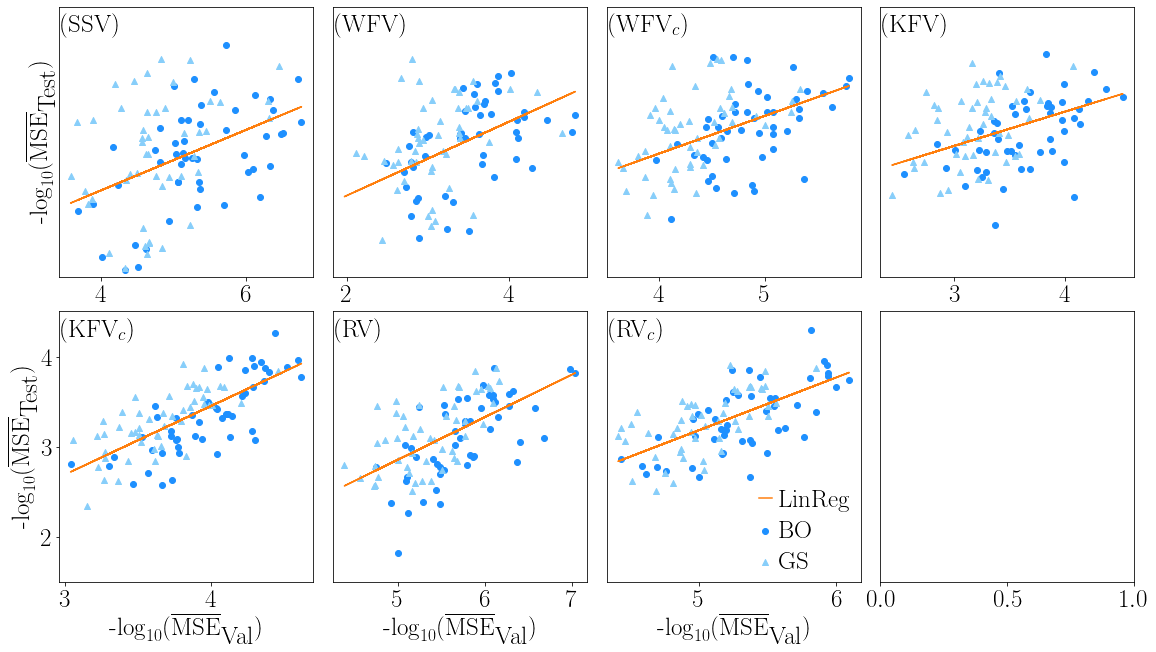

In [6]:
from scipy.stats import linregress
import scipy

def scatter(ymin,ymax):

    plt.rcParams["figure.figsize"] = (16,9)
    plt.rcParams["font.size"] = 25

    titles = ['-$\log_{10}(\overline{\\textrm{MSE}}_{\\textrm{Val}}$)',
                  '-$\log_{10}(\overline{\\textrm{MSE}}_{\\textrm{Test}}$)']

    ax, fig = plt.subplots(2,4)

    print('Spearman Coefficients/Pearson Coefficients')

    x = -np.append(Min_25G[:,2], Min_50G[:,2])
    y = -np.append(res_BO[:,0], res_Gr[:,0])

    plt.subplot(2,4,1)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    print('ssv',scipy.stats.spearmanr(x,y)[0],'/',r_value)

    plt.ylabel(titles[1])

    plt.scatter(x[:50], y[:50], marker='o', c='dodgerblue')
    plt.scatter(x[50:], y[50:], marker='^', c='lightskyblue') 
    plt.ylim(ymin,ymax)
    plt.plot(x, slope*x+intercept, 'C1')
    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False) # labels along the bottom edge are off

    plt.annotate('(SSV)', xy=(0, 1), xytext=(+2, -6), va='top', ha='left',
                 xycoords='axes fraction', textcoords='offset points')

    x = -np.append(Min_25G_mmv[:,2], Min_50G_mmv[:,2])
    y = -np.append(res_BO_mmv[:,0], res_Gr_mmv[:,0])

    plt.subplot(2,4,7)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    print('rvc',scipy.stats.spearmanr(x,y)[0],'/',r_value)

    plt.xlabel(titles[0])

    plt.scatter(x[:50], y[:50], marker='o', c='dodgerblue', label='BO')
    plt.scatter(x[50:], y[50:], marker='^', c='lightskyblue', label='GS') 
    plt.plot(x, slope*x+intercept, 'C1', label='LinReg')
    plt.ylim(ymin,ymax)
    plt.plot(x, slope*x+intercept, 'C1')
    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False) # labels along the bottom edge are off

    plt.legend(loc='lower right', frameon=False, handlelength=0.5, handletextpad=.3,
                   labelspacing=.3, bbox_to_anchor=(1.05,-0.05))

    plt.annotate('(RV$_c$)', xy=(0, 1), xytext=(+2, -6), va='top', ha='left',
                 xycoords='axes fraction', textcoords='offset points')

    x = -np.append(Min_25G_mv[:,2], Min_50G_mv[:,2])
    y = -np.append(res_BO_mv[:,0], res_Gr_mv[:,0])

    plt.subplot(2,4,6)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    print('rv',scipy.stats.spearmanr(x,y)[0],'/',r_value)
    plt.xlabel(titles[0])

    plt.scatter(x[:50], y[:50], marker='o', c='dodgerblue')
    plt.scatter(x[50:], y[50:], marker='^', c='lightskyblue') 
    plt.ylim(ymin,ymax)
    plt.plot(x, slope*x+intercept, 'C1')
    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False) # labels along the bottom edge are off

    plt.annotate('(RV)', xy=(0, 1), xytext=(+2, -6), va='top', ha='left',
                 xycoords='axes fraction', textcoords='offset points')

    x = -np.append(Min_25G_kfv[:,2], Min_50G_kfv[:,2])
    y = -np.append(res_BO_kfv[:,0], res_Gr_kfv[:,0])

    plt.subplot(2,4,4)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    print('kfv',scipy.stats.spearmanr(x,y)[0],'/',r_value)


    plt.scatter(x[:50], y[:50], marker='o', c='dodgerblue')
    plt.scatter(x[50:], y[50:], marker='^', c='lightskyblue') 
    plt.ylim(ymin,ymax)
    plt.plot(x, slope*x+intercept, 'C1')
    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False) # labels along the bottom edge are off

    plt.annotate('(KFV)', xy=(0, 1), xytext=(+2, -6), va='top', ha='left',
                 xycoords='axes fraction', textcoords='offset points')

    x = -np.append(Min_25G_kfo[:,2], Min_50G_kfo[:,2])
    y = -np.append(res_BO_kfo[:,0], res_Gr_kfo[:,0])

    plt.subplot(2,4,5)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    print('kfo',scipy.stats.spearmanr(x,y)[0],'/',r_value)

    plt.scatter(x[:50], y[:50], marker='o', c='dodgerblue')
    plt.scatter(x[50:], y[50:], marker='^', c='lightskyblue') 
    plt.plot(x, slope*x+intercept, 'C1')
    plt.ylim(ymin,ymax)
    plt.xlabel(titles[0])
    plt.ylabel(titles[1])

    plt.annotate('(KFV$_c$)', xy=(0, 1), xytext=(+2, -6), va='top', ha='left',
                 xycoords='axes fraction', textcoords='offset points')

    x = -np.append(Min_25G_wfc[:,2], Min_50G_wfc[:,2])
    y = -np.append(res_BO_wfc[:,0], res_Gr_wfc[:,0])

    plt.subplot(2,4,3)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    print('wfc',scipy.stats.spearmanr(x,y)[0],'/',r_value)


    plt.scatter(x[:50], y[:50], marker='o', c='dodgerblue')
    plt.scatter(x[50:], y[50:], marker='^', c='lightskyblue') 
    plt.ylim(ymin,ymax)
    plt.plot(x, slope*x+intercept, 'C1')
    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False) # labels along the bottom edge are off

    plt.annotate('(WFV$_c$)', xy=(0, 1), xytext=(+2, -6), va='top', ha='left',
                 xycoords='axes fraction', textcoords='offset points')

    x = -np.append(Min_25G_wfv[:,2], Min_50G_wfv[:,2])
    y = -np.append(res_BO_wfv[:,0], res_Gr_wfv[:,0])

    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    print('wfv',scipy.stats.spearmanr(x,y)[0],'/',r_value)


    plt.subplot(2,4,2)

    plt.scatter(x[:50], y[:50], marker='o', c='dodgerblue')
    plt.scatter(x[50:], y[50:], marker='^', c='lightskyblue') 
    plt.plot(x, slope*x+intercept, 'C1')
    plt.ylim(ymin,ymax)
    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False) # labels along the bottom edge are off

    plt.annotate('(WFV)', xy=(0, 1), xytext=(+2, -6), va='top', ha='left',
                 xycoords='axes fraction', textcoords='offset points')

    plt.subplot(2,4,8)
    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False) # labels along the bottom edge are off

    ax.tight_layout(pad=0.2)

    plt.show()
    
scatter(1.5,4.5)


## 900 Grid points MSE reconstruction
Obtained from save_gp_reconstruction=True in Validation_Short_Lorenz.ipynb

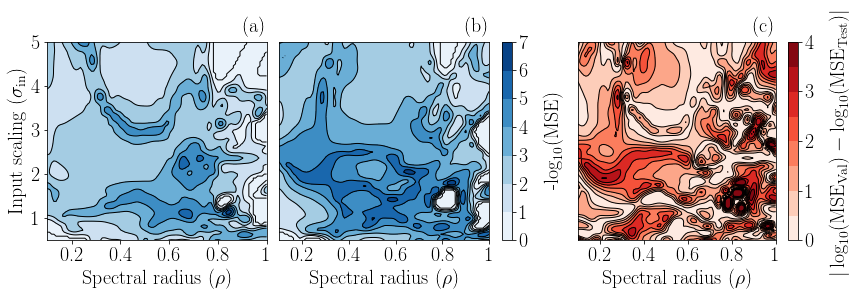

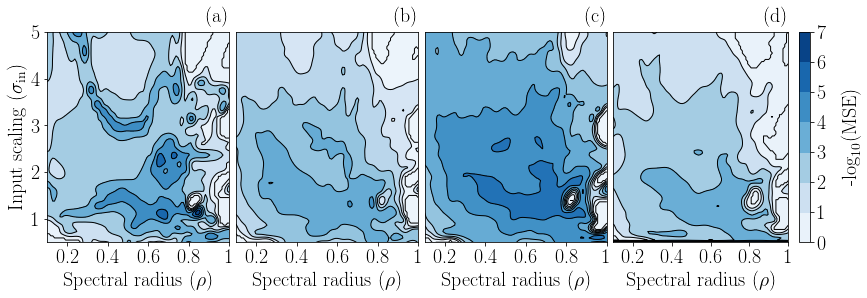

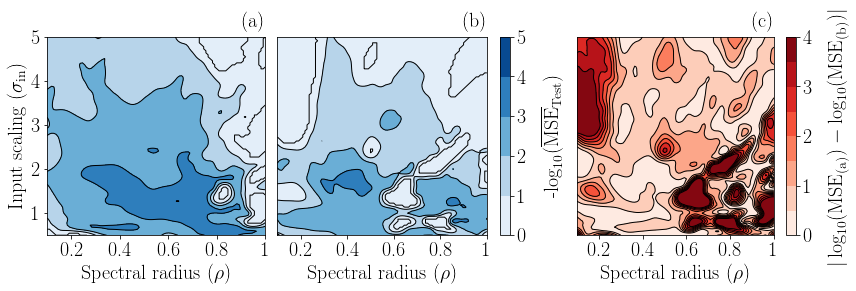

In [7]:
# First and second realization data obtained by running a grid search with 30 n_grid 
# in the test set in Validation_Short_Lorenz.ipynb using val=Test
# and saving xx, yy, and y_pred in the Gaussian Process reconstruction
fln = './data/SL_GP_ 900_Test.h5'
hf = h5py.File(fln,'r')
xx_val = np.array(hf.get('xx'))
yy_val = np.array(hf.get('yy'))
yp_val = -np.array(hf.get('y_pred'))[0]
yp_tes = -np.array(hf.get('y_pred'))[1]
hf.close()

# First realization data obtained by running a grid search with 30 n_grid 
# in the interval from 12LT to 15LT via Validation_Short_Lorenz.ipynb using val=Test1
# and saving xx, yy, and y_pred in the Gaussian Process reconstruction
fln = './data/SL_GP_ 900_Test1.h5'
hf = h5py.File(fln,'r')
xx_tes  = np.array(hf.get('xx'))
yy_tes  = np.array(hf.get('yy'))
yp_tes1 = -np.array(hf.get('y_pred'))[0]
hf.close()

# First realization data obtained by running a grid search with 30 n_grid for different 
# val=SSV, etc in Validation_Short_Lorenz.ipynb
# and saving xx, yy, and y_pred in the Gaussian Process reconstruction
fln = './data/SL_GP_ 900_SSV.h5'
hf = h5py.File(fln,'r')
xx_val = np.array(hf.get('xx'))
yy_val = np.array(hf.get('yy'))
yp_valS = -np.array(hf.get('y_pred'))[0]
hf.close()

fln = './data/SL_GP_ 900_RVC.h5'
hf = h5py.File(fln,'r')
xx_val = np.array(hf.get('xx'))
yy_val = np.array(hf.get('yy'))
yp_valR = -np.array(hf.get('y_pred'))[0]
hf.close()

fln = './data/SL_GP_ 900_KFC.h5'
hf = h5py.File(fln,'r')
xx_val = np.array(hf.get('xx'))
yy_val = np.array(hf.get('yy'))
yp_valK = -np.array(hf.get('y_pred'))[0]
hf.close()

## Comparison different intervals SSV (val vs 1st interval in test)

plt.rcParams["figure.figsize"] = (12,4)
plt.rcParams["font.size"] = 20

axx = plt.figure()
gs = GridSpec(1, 2, width_ratios=[2., 1.], figure=axx, wspace=0.1)

gs00 = GridSpecFromSubplotSpec(1, 2, width_ratios=[1., 1.2], subplot_spec=gs[0], wspace=0.05)

ax = axx.add_subplot(gs00[0])
yp_val1 = -np.clip(-yp_valS,a_min=0,a_max=7.)
ax.set_yticks([1,2,3,4,5,6])
ax.set_xticks([0.2,0.4,0.6,.8,1])
ax.set_xticklabels(['0.2','0.4','0.6','0.8','1'])
plt.ylabel('Input scaling ($\sigma_{\mathrm{in}}$)')
plt.xlabel('Spectral radius ($\\rho$)')
CS      = plt.contourf(xx_val, yy_val, -yp_val1,levels=7,cmap='Blues',vmax=7)
CSa     = plt.contour(xx_val, yy_val, -yp_val1, levels=7,colors='black',
                      linewidths=1, linestyles='solid',vmax=7)
plt.annotate('(a)', xy=(1, 1), xytext=(-0, +25), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points')

ax = axx.add_subplot(gs00[1])
yp_tes11 = -np.clip(-yp_tes1,a_min=.0,a_max=7.)
plt.xlabel('Spectral radius ($\\rho$)')
ax.set_yticks([1,2,3,4,5,6])
ax.set_xticks([0.2,0.4,0.6,.8,1])
ax.set_xticklabels(['0.2','0.4','0.6','0.8','1'])
plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False) # labels along the bottom edge are off
CS      = plt.contourf(xx_tes, yy_tes, -yp_tes11,levels=7,cmap='Blues',vmax=7)
cbar = plt.colorbar(ticks=[0,1,2,3,4,5,6,7])
cbar.set_label('-$\log_{10}$(MSE)',labelpad=15)
CSa     = plt.contour(xx_tes, yy_tes, -yp_tes11, levels=7,colors='black',
                      linewidths=1, linestyles='solid',vmax=7)
plt.annotate('(b)', xy=(1, 1), xytext=(-0, +25), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points')

ax = axx.add_subplot(gs[1])
err = np.clip(np.abs(yp_tes1-yp_valS), a_min=0,a_max=4)
ax.set_yticks([1,2,3,4,5,6])
ax.set_xticks([0.2,0.4,0.6,.8,1])
ax.set_xticklabels(['0.2','0.4','0.6','0.8','1'])
plt.xlabel('Spectral radius ($\\rho$)')
plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False) # labels along the bottom edge are off
CS   = plt.contourf(xx_tes, yy_tes, err,levels=7,cmap='Reds')
cbar = plt.colorbar(ticks=[0,1,2,3,4,5])
cbar.set_label('$|\log_{10}(\mathrm{MSE}_{\mathrm{Val}}) - \log_{10}(\mathrm{MSE}_{\mathrm{Test}})|$',
               labelpad=15)
CSa     = plt.contour(xx_tes, yy_tes, err, levels=7,colors='black',
                      linewidths=1, linestyles='solid')
plt.annotate('(c)', xy=(1, 1), xytext=(-0, +25), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points')

gs.tight_layout(axx,pad=0.4)


## Comparison Different Validation Strategies

plt.rcParams["figure.figsize"] = (12,4)
plt.rcParams["font.size"] = 20

axx = plt.figure()
gs0 = GridSpec(1, 4, width_ratios=[1., 1., 1., 1.2], wspace=0.1)

ax = axx.add_subplot(gs0[3])
yp_val1 = -np.clip(-yp_val,a_min=0,a_max=7.)
yp_val1[0] = -6.5 #to have the right bars in the color bar
ax.set_yticks([1,2,3,4,5,6])
ax.set_xticks([0.2,0.4,0.6,.8,1])
ax.set_xticklabels(['0.2','0.4','0.6','0.8','1'])
plt.xlabel('Spectral radius ($\\rho$)')
CS      = plt.contourf(xx_val, yy_val, -yp_val1,levels=6,cmap='Blues',vmax=7)
cbar    = plt.colorbar(ticks=[0,1,2,3,4,5,6,7])
cbar.set_label('-$\log_{10}(\mathrm{MSE})$',labelpad=15)
CSa     = plt.contour(xx_val, yy_val, -yp_val1, levels=6,colors='black',
                      linewidths=1, linestyles='solid',vmax=5)
plt.annotate('(d)', xy=(1, 1), xytext=(-0, +25), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points')
plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False) # labels along the bottom edge are off

ax = axx.add_subplot(gs0[0])
yp_val1 = -np.clip(-yp_valS,a_min=0,a_max=7.)
ax.set_yticks([1,2,3,4,5,6])
ax.set_xticks([0.2,0.4,0.6,.8,1])
ax.set_xticklabels(['0.2','0.4','0.6','0.8','1'])
plt.xlabel('Spectral radius ($\\rho$)')
plt.ylabel('Input scaling ($\sigma_{\mathrm{in}}$)')
CS      = plt.contourf(xx_val, yy_val, -yp_val1,levels=6,cmap='Blues',vmax=7)
CSa     = plt.contour(xx_val, yy_val, -yp_val1, levels=6,colors='black',
                      linewidths=1, linestyles='solid',vmax=7)
plt.annotate('(a)', xy=(1, 1), xytext=(-0, +25), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points')


ax = axx.add_subplot(gs0[1])
yp_val1 = -np.clip(-yp_valK,a_min=0,a_max=7.)
ax.set_yticks([1,2,3,4,5,6])
ax.set_xticks([0.2,0.4,0.6,.8,1])
ax.set_xticklabels(['0.2','0.4','0.6','0.8','1'])
plt.xlabel('Spectral radius ($\\rho$)')
CS      = plt.contourf(xx_val, yy_val, -yp_val1,levels=6,cmap='Blues',vmax=7)
CSa     = plt.contour(xx_val, yy_val, -yp_val1, levels=6,colors='black',
                      linewidths=1, linestyles='solid',vmax=5)
plt.annotate('(b)', xy=(1, 1), xytext=(-0, +25), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points')
plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False) # labels along the bottom edge are off

ax = axx.add_subplot(gs0[2])
yp_val1 = -np.clip(-yp_valR,a_min=0,a_max=7.)
ax.set_xticks([0.2,0.4,0.6,.8,1])
ax.set_xticklabels(['0.2','0.4','0.6','0.8','1'])
plt.xlabel('Spectral radius ($\\rho$)')
CS      = plt.contourf(xx_val, yy_val, -yp_val1,levels=6,cmap='Blues',vmax=7)
CSa     = plt.contour(xx_val, yy_val, -yp_val1, levels=6,colors='black',
                      linewidths=1, linestyles='solid',vmax=5)
plt.annotate('(c)', xy=(1, 1), xytext=(-0, +25), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points')
plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False) # labels along the bottom edge are off


gs0.tight_layout(figure=axx,pad=0.1)

## Comparison Different Realizations in the test set

plt.rcParams["figure.figsize"] = (12,4)
plt.rcParams["font.size"] = 20

axx = plt.figure()
gs = GridSpec(1, 2, width_ratios=[2., 1.], figure=axx, wspace=0.1)

gs00 = GridSpecFromSubplotSpec(1, 2, width_ratios=[1., 1.2], subplot_spec=gs[0], wspace=0.05)

ax = axx.add_subplot(gs00[0])
yp_val1 = -np.clip(-yp_val,a_min=0,a_max=5.)
ax.set_yticks([1,2,3,4,5,6])
ax.set_xticks([0.2,0.4,0.6,.8,1])
ax.set_xticklabels(['0.2','0.4','0.6','0.8','1'])
plt.ylabel('Input scaling ($\sigma_{\mathrm{in}}$)')
plt.xlabel('Spectral radius ($\\rho$)')
CS      = plt.contourf(xx_val, yy_val, -yp_val1,levels=4,cmap='Blues',vmax=5)
CSa     = plt.contour(xx_val, yy_val, -yp_val1, levels=4,colors='black',
                      linewidths=1, linestyles='solid',vmax=5)
plt.annotate('(a)', xy=(1, 1), xytext=(-0, +25), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points')


ax = axx.add_subplot(gs00[1])
yp_tes1 = -np.clip(-yp_tes,a_min=.0,a_max=5.)
yp_tes1[0,0] = -4.1 # just to have the right bars in the color bar
plt.xlabel('Spectral radius ($\\rho$)')
ax.set_yticks([1,2,3,4,5,6])
ax.set_xticks([0.2,0.4,0.6,.8,1])
ax.set_xticklabels(['0.2','0.4','0.6','0.8','1'])
plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False) # labels along the bottom edge are off
CS      = plt.contourf(xx_val, yy_val, -yp_tes1,levels=4,cmap='Blues',vmax=5)
cbar = plt.colorbar(ticks=[0,1,2,3,4,5,6,7])
cbar.set_label('-$\log_{10}(\overline{\mathrm{MSE}}_{\mathrm{Test}})$',labelpad=15)
CSa     = plt.contour(xx_val, yy_val, -yp_tes1, levels=4,colors='black',
                      linewidths=1, linestyles='solid',vmax=5)
plt.annotate('(b)', xy=(1, 1), xytext=(-0, +25), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points')

ax = axx.add_subplot(gs[1])
err = np.clip(np.abs(yp_tes-yp_val), a_min=0,a_max=4)
ax.set_yticks([1,2,3,4,5,6])
ax.set_xticks([0.2,0.4,0.6,.8,1])
ax.set_xticklabels(['0.2','0.4','0.6','0.8','1'])
plt.xlabel('Spectral radius ($\\rho$)')
plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False) # labels along the bottom edge are off
CS   = plt.contourf(xx_val, yy_val, err,levels=7,cmap='Reds')
cbar = plt.colorbar(ticks=[0,1,2,3,4,5])
cbar.set_label('$|\log_{10}(\mathrm{MSE}_{\mathrm{(a)}}) - \log_{10}(\mathrm{MSE}_{\mathrm{(b)}})|$',
               labelpad=15)
CSa     = plt.contour(xx_val, yy_val, err, levels=7,colors='black',
                      linewidths=1, linestyles='solid')
plt.annotate('(c)', xy=(1, 1), xytext=(-0, +25), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points')

gs.tight_layout(axx,pad=0.4)
plt.show()


## Performance in the test Set

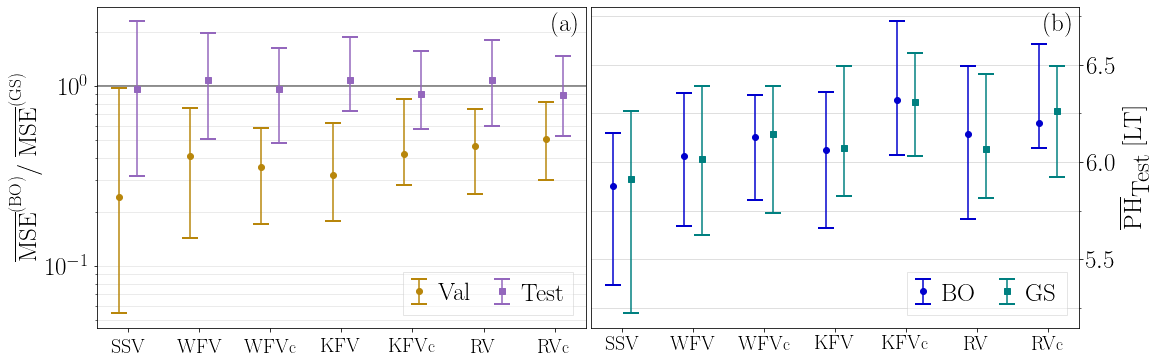

In [10]:
def err_bars():

    #Computing the ratio of the MSE between validation and test
    x_ssv = 10**(Min_25G[:,2] - Min_50G[:,2])
    y_ssv = 10**(res_BO[:,0]  - res_Gr[:,0])
    x_wfv = 10**(Min_25G_wfv[:,2] - Min_50G_wfv[:,2]) 
    y_wfv = 10**(res_BO_wfv[:,0]  - res_Gr_wfv[:,0])
    x_wfc = 10**(Min_25G_wfc[:,2] - Min_50G_wfc[:,2]) 
    y_wfc = 10**(res_BO_wfc[:,0]  - res_Gr_wfc[:,0])
    x_kfv = 10**(Min_25G_kfv[:,2] - Min_50G_kfv[:,2]) 
    y_kfv = 10**(res_BO_kfv[:,0]  - res_Gr_kfv[:,0])
    x_kfo = 10**(Min_25G_kfo[:,2] - Min_50G_kfo[:,2]) 
    y_kfo = 10**(res_BO_kfo[:,0]  - res_Gr_kfo[:,0])
    x_mv = 10**(Min_25G_mv[:,2] - Min_50G_mv[:,2] )
    y_mv = 10**(res_BO_mv[:,0]  - res_Gr_mv[:,0])
    x_mmv = 10**(Min_25G_mmv[:,2] - Min_50G_mmv[:,2]) 
    y_mmv = 10**(res_BO_mmv[:,0]  - res_Gr_mmv[:,0])


    plt.rcParams["figure.figsize"] = (16,5)
    plt.rcParams["font.size"] = 25


    plt.rcParams['xtick.major.pad']='8'

    plt.subplots(1,2)
    ## plotting the ratio of the MSE between validation and test

    q_1 = .25
    q_2 = 1 - q_1

    med  = np.array([np.median(y_ssv),np.median(y_wfv),
                     np.median(y_wfc),np.median(y_kfv),
                     np.median(y_kfo),np.median(y_mv),np.median(y_mmv)])
    q_i  = np.array([np.quantile(y_ssv,q_1),np.quantile(y_wfv,q_1),np.quantile(y_wfc,q_1),
                     np.quantile(y_kfv,q_1),np.quantile(y_kfo,q_1),
                     np.quantile(y_mv,q_1),np.quantile(y_mmv,q_1)])
    q_f  = np.array([np.quantile(y_ssv,q_2),np.quantile(y_wfv,q_2),np.quantile(y_wfc,q_2),
                     np.quantile(y_kfv,q_2),np.quantile(y_kfo,q_2),
                     np.quantile(y_mv,q_2),np.quantile(y_mmv,q_2)])

    medx  = np.array([np.median(x_ssv),np.median(x_wfv)
                      ,np.median(x_wfc),np.median(x_kfv),
                     np.median(x_kfo),np.median(x_mv),np.median(x_mmv)])
    q_ix  = np.array([np.quantile(x_ssv,q_1),np.quantile(x_wfv,q_1),np.quantile(x_wfc,q_1),
                     np.quantile(x_kfv,q_1),np.quantile(x_kfo,q_1),
                     np.quantile(x_mv,q_1),np.quantile(x_mmv,q_1)])
    q_fx  = np.array([np.quantile(x_ssv,q_2),np.quantile(x_wfv,q_2),np.quantile(x_wfc,q_2),
                     np.quantile(x_kfv,q_2),np.quantile(x_kfo,q_2),
                     np.quantile(x_mv,q_2),np.quantile(x_mmv,q_2)])

    medd = np.concatenate((med,medx))

    yerr  = np.column_stack((med - q_i, q_f - med)).transpose()
    xerr  = np.column_stack((medx - q_ix, q_fx - medx)).transpose()

    x_BO = np.array([10,14,18,22,26,30,34])
    x_Gr = x_BO+1
    x_ticks = x_BO+0.5

    ax = plt.subplot(1,2,1)

    plt.grid(True, which="both", axis='y', ls="-", alpha=0.3)
    plt.ylabel('$\overline{\mathrm{MSE}}^{(\mathrm{BO})} / \; \overline{\mathrm{MSE}}^{(\mathrm{GS})}$')
#     plt.ylim(0.05,5)
    plt.yscale('log')
    plt.errorbar(x_BO,y=medx,yerr=xerr,linestyle=' ',color='darkgoldenrod', marker='o',
                 capsize=8, capthick=2, label='Val')
    plt.errorbar(x_Gr,y=med,yerr=yerr,linestyle=' ',color='tab:purple', marker='s',
                 capsize=8, capthick=2, label='Test')
    ax.set_xticks(x_ticks[:7])
    ax.set_xticklabels(['SSV', 'WFV', 'WFV{\LARGE c}', 'KFV', 'KFV{\LARGE c}', 'RV',
                        'RV{\LARGE c}'], fontsize=20)

    plt.annotate('(a)', xy=(1, 1), xytext=(-5, -5), va='top', ha='right',
                 xycoords='axes fraction', textcoords='offset points')
    plt.legend(loc='lower right', ncol=2, handletextpad=0.5, columnspacing=1., handlelength=0.5,
               frameon=True,
               fancybox=False, framealpha=0.5)
    plt.axhline(1, c='k', zorder=-5, alpha=.6)


    ax = plt.subplot(1,2,2)
    # plotting the Prediction Horizon in the test set

    med  = np.array([np.median(res_BO[:,1]),np.median(res_BO_wfv[:,1]),
                     np.median(res_BO_wfc[:,1]),np.median(res_BO_kfv[:,1]),
                     np.median(res_BO_kfo[:,1]),np.median(res_BO_mv[:,1]),np.median(res_BO_mmv[:,1])])
    q_i  = np.array([np.quantile(res_BO[:,1],q_1),
                     np.quantile(res_BO_wfv[:,1],q_1),
                     np.quantile(res_BO_wfc[:,1],q_1),
                     np.quantile(res_BO_kfv[:,1],q_1),
                     np.quantile(res_BO_kfo[:,1],q_1),
                     np.quantile(res_BO_mv[:,1],q_1),
                     np.quantile(res_BO_mmv[:,1],q_1)])
    q_f  = np.array([np.quantile(res_BO[:,1],q_2),
                     np.quantile(res_BO_wfv[:,1],q_2),
                     np.quantile(res_BO_wfc[:,1],q_2),
                     np.quantile(res_BO_kfv[:,1],q_2,),
                     np.quantile(res_BO_kfo[:,1],q_2,),
                     np.quantile(res_BO_mv[:,1] ,q_2,),
                     np.quantile(res_BO_mmv[:,1],q_2,)])

    medx  = np.array([np.median(res_Gr[:,1]),np.median(res_Gr_wfv[:,1]),
                     np.median(res_Gr_wfc[:,1]),np.median(res_Gr_kfv[:,1]),
                     np.median(res_Gr_kfo[:,1]),np.median(res_Gr_mv[:,1]),np.median(res_Gr_mmv[:,1])])
    q_ix  = np.array([np.quantile(res_Gr[:,1],q_1,),
                     np.quantile(res_Gr_wfv[:,1],q_1,),
                     np.quantile(res_Gr_wfc[:,1],q_1,),
                     np.quantile(res_Gr_kfv[:,1],q_1,),
                     np.quantile(res_Gr_kfo[:,1],q_1,),
                     np.quantile(res_Gr_mv[:,1],q_1,),
                     np.quantile(res_Gr_mmv[:,1],q_1,)])
    q_fx  = np.array([np.quantile(res_Gr[:,1],q_2,),
                     np.quantile(res_Gr_wfv[:,1],q_2,),
                     np.quantile(res_Gr_wfc[:,1],q_2,),
                     np.quantile(res_Gr_kfv[:,1],q_2,),
                     np.quantile(res_Gr_kfo[:,1],q_2,),
                     np.quantile(res_Gr_mv[:,1],q_2,),
                     np.quantile(res_Gr_mmv[:,1],q_2,)])

    idx=7

    yerr  = np.column_stack((med - q_i, q_f - med)).transpose()
    yerrx  = np.column_stack((medx - q_ix, q_fx - medx)).transpose()

    plt.grid(True, which="both", axis='y', ls="-", alpha=0.5)
    plt.ylabel('$\overline{\\textrm{PH}}_{\\textrm{Test}}$ [LT]')#' / \, \overline{\\textrm{MSE}}_{\\textrm{GS}}$')
#     plt.ylim(5.00,6.75)
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1/2))
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1/4))
    ax.set_xticks(x_ticks[:7])
    ax.set_xticklabels(['SSV', 'WFV', 'WFV{\LARGE c}', 'KFV', 'KFV{\LARGE c}', 'RV',
                        'RV{\LARGE c}'], fontsize=20)
    ax.tick_params(axis='x', which='major', pad=5)
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    plt.errorbar(x_BO[:idx],y=med[:idx],yerr=yerr[:,:idx],linestyle=' ',color='mediumblue',
                 marker='o',
                 capsize=8, capthick=2, label='BO')
    plt.errorbar(x_Gr[:idx],y=medx[:idx],yerr=yerrx[:,:idx],linestyle=' ',color='teal', marker='s',
                 capsize=8, capthick=2, label='GS') 

    plt.annotate('(b)', xy=(1, 1), xytext=(-5, -5), va='top', ha='right',
                 xycoords='axes fraction', textcoords='offset points')

    plt.legend(loc='lower right', ncol=2, handletextpad=0.5, columnspacing=1., handlelength=0.5,
               frameon=True,
               fancybox=False, framealpha=0.5)

    plt.tight_layout(pad=0.2)

    plt.show()
    
err_bars()

## Fixed Hyperparameters
We show the comparison between using a fixed set of hyperparameters and optimizing the networks independently. Can be found in the Appendix of the paper.

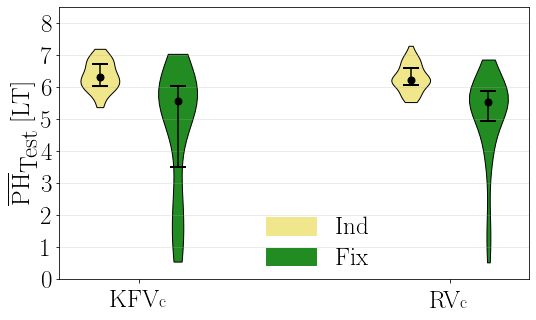

In [28]:
fln = './data/Short_Lorenz_PostProc_fix.h5'
hf = h5py.File(fln,'r')
fixed_mmv  = np.array(hf.get('res_BO_mmv_fix'))[:,1]
fixed_kfo  = np.array(hf.get('res_BO_kfo_fix'))[:,1]
hf.close()

BO_mmv       = res_BO_mmv[:,1].copy()
BO_kfo       = res_BO_kfo[:,1].copy()

q_1 = .25
q_2 = 1 - q_1

x_BO = np.array([9,10,13,14])
x_ticks = np.array([9.5,13.5])

plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams["font.size"] = 25
plt.rcParams['xtick.major.pad']='8'

fig, ax = plt.subplots(1,1)

ax1 = plt.subplot(1,1,1)


viol_res = np.column_stack((BO_kfo,fixed_kfo,BO_mmv,fixed_mmv))

med  = np.array([np.median(BO_kfo),np.median(fixed_kfo),
                 np.median(BO_mmv),np.median(fixed_mmv)])
q_i  = np.array([np.quantile(BO_kfo,q_1),np.quantile(fixed_kfo,q_1),
                 np.quantile(BO_mmv,q_1),np.quantile(fixed_mmv,q_1)])
q_f  = np.array([np.quantile(BO_kfo,q_2),np.quantile(fixed_kfo,q_2),
                 np.quantile(BO_mmv,q_2),np.quantile(fixed_mmv,q_2)])

yerr  = np.column_stack((med - q_i, q_f - med)).transpose()

plt.grid(True, which="both",  axis='y', ls="-", alpha=0.3)
plt.ylabel('$\overline{\\textrm{PH}}_{\\textrm{Test}}$ [LT]')
plt.ylim(0., 8.5)
ax1.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
plt.xticks(x_ticks, ['KFV{\LARGE c}','RV{\LARGE c}'])

plt.errorbar(x_BO,y=med,yerr=yerr,linestyle=' ',color='k', marker='.', markersize=14,
             capsize=8, capthick=2)

labels = []
def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))
    
# so that the widths of the violin plots are representative of pdfs
real_width=False
if real_width:
    width1 = np.histogram(BO_kfo,bins=5,density=True)[0].max()
    width2 = np.histogram(fixed_kfo,bins=5,density=True)[0].max()
    width3 = np.histogram(BO_mmv,bins=5,density=True)[0].max()
    width4 = np.histogram(fixed_mmv,bins=5,density=True)[0].max()
    Width = np.array([width1,width2,width3,width4]).max()
else:
    width1, width2, width3, width4, Width = np.ones(5)

parts  = plt.violinplot(viol_res[:,[0,2]],x_BO[[0,2]],
                        showmedians=False, showextrema=False,points=30,
                        widths=.5*np.array([width1/Width,width3/Width]))
parts1 = plt.violinplot(viol_res[:,[1,3]],x_BO[[1,3]],
                        showmedians=False, showextrema=False,points=30,
                        widths=.5*np.array([width2/Width,width4/Width]))

import matplotlib.patches as mpatches

for pc in parts['bodies']:
    pc.set_facecolor('khaki')
    pc.set_edgecolor('black')
    pc.set_alpha(1.)
add_label(parts, "Ind")
    
for pc in parts1['bodies']:
    pc.set_facecolor('forestgreen')
    pc.set_edgecolor('black')
    pc.set_alpha(1.)
add_label(parts1, 'Fix')

ax1.legend(*zip(*labels), bbox_to_anchor=(.55,-0.05), loc='lower center',
           frameon=False, labelspacing=0.3)

fig.tight_layout()


## Model-Informed performance

In [11]:
######## Load from Validation Runs for model-informed architecture

# Obtained by running Validation_Short_Lorenz.ipynb
# minimum is (size_ensemble, 3), for each network we have stored the optimal parameters and optimal MSE
# each h5 file is a different run of Validation_Short_Lorenz.ipynb 

# #BO and Grid Search in SSV
hf       = h5py.File('./data/Lor_short_SSV_50_5_MI.h5','r')
Min_25G  = np.array(hf.get('minimum'))
hf.close()

hf       = h5py.File('./data/Lor_short_SSV_50_7_MI.h5','r')
Min_50G  = np.array(hf.get('minimum'))
hf.close()

# #BO and Grid Search in RVC 
hf       = h5py.File('./data/Lor_short_RVC_50_5_MI.h5','r')
Min_25G_mmv  = np.array(hf.get('minimum'))
hf.close()

# hf       = h5py.File('./data/FrNp_8_3MSE_Bias_MMV_Log_50G_50_49_0_MI.h5','r')
hf       = h5py.File('./data/Lor_short_RVC_50_7_MI.h5','r')
Min_50G_mmv  = np.array(hf.get('minimum'))
hf.close()

# BO and Grid Search in WFV
hf       = h5py.File('./data/Lor_short_WFV_50_5_MI.h5','r')
Min_25G_wfv  = np.array(hf.get('minimum'))
hf.close()

hf       = h5py.File('./data/Lor_short_WFV_50_7_MI.h5','r')
Min_50G_wfv  = np.array(hf.get('minimum'))
hf.close()

#BO and Grid Search in KFV 
hf       = h5py.File('./data/Lor_short_KFV_50_5_MI.h5','r')
Min_25G_kfv  = np.array(hf.get('minimum'))
hf.close()

hf       = h5py.File('./data/Lor_short_KFV_50_7_MI.h5','r')
Min_50G_kfv  = np.array(hf.get('minimum'))
hf.close()

#BO and Grid Search in RV 
hf       = h5py.File('./data/Lor_short_RV_50_5_MI.h5','r')
Min_25G_mv  = np.array(hf.get('minimum'))
hf.close()

hf       = h5py.File('./data/Lor_short_RV_50_7_MI.h5','r')
Min_50G_mv  = np.array(hf.get('minimum'))
hf.close()

#BO and Grid Search in KFC
hf       = h5py.File('./data/Lor_short_KFC_50_5_MI.h5','r')
Min_25G_kfo  = np.array(hf.get('minimum'))
hf.close()

hf       = h5py.File('./data/Lor_short_KFC_50_7_MI.h5','r')
Min_50G_kfo  = np.array(hf.get('minimum'))
hf.close()

#BO and Grid Search WFC
hf       = h5py.File('./data/Lor_short_WFC_50_5_MI.h5','r')
Min_25G_wfc  = np.array(hf.get('minimum'))
hf.close()

hf       = h5py.File('./data/Lor_short_WFC_50_7_MI.h5','r')
Min_50G_wfc  = np.array(hf.get('minimum'))
hf.close()

########Load Test Results

#obtained from TestSet_Short_Lorenz.ipynb
#res are (size_ensemble, 2). For each network we have the MSE and PH in the test set for the optimal hyperparameters

fln = './data/Short_Lorenz_PostProc_MI.h5'

hf          = h5py.File(fln,'r')
res_Gr      = np.array(hf.get('res_Gr     '))
res_BO      = np.array(hf.get('res_BO     '))
res_Gr_mmv  = np.array(hf.get('res_Gr_mmv '))
res_BO_mmv  = np.array(hf.get('res_BO_mmv '))
res_Gr_mv   = np.array(hf.get('res_Gr_mv  '))
res_BO_mv   = np.array(hf.get('res_BO_mv  '))
res_Gr_kfv  = np.array(hf.get('res_Gr_kfv '))
res_BO_kfv  = np.array(hf.get('res_BO_kfv '))
res_Gr_kfo  = np.array(hf.get('res_Gr_kfo '))
res_BO_kfo  = np.array(hf.get('res_BO_kfo '))
res_Gr_wfc  = np.array(hf.get('res_Gr_wfc '))
res_BO_wfc  = np.array(hf.get('res_BO_wfc '))
res_Gr_wfv  = np.array(hf.get('res_Gr_wfv '))
res_BO_wfv  = np.array(hf.get('res_BO_wfv '))

hf.close()

Spearman Coefficients/Pearson Coefficients
ssv 0.148010801080108 / 0.1741418037435763
rvc 0.4768436843684367 / 0.5265912239781381
rv 0.3607200720072007 / 0.4236732683276724
kfv 0.38527452745274526 / 0.43220673752005623
kfo 0.4789438943894389 / 0.5259618483587047
wfc 0.33430543054305434 / 0.39511380202854834
wfv 0.2488208820882088 / 0.2499583403794183


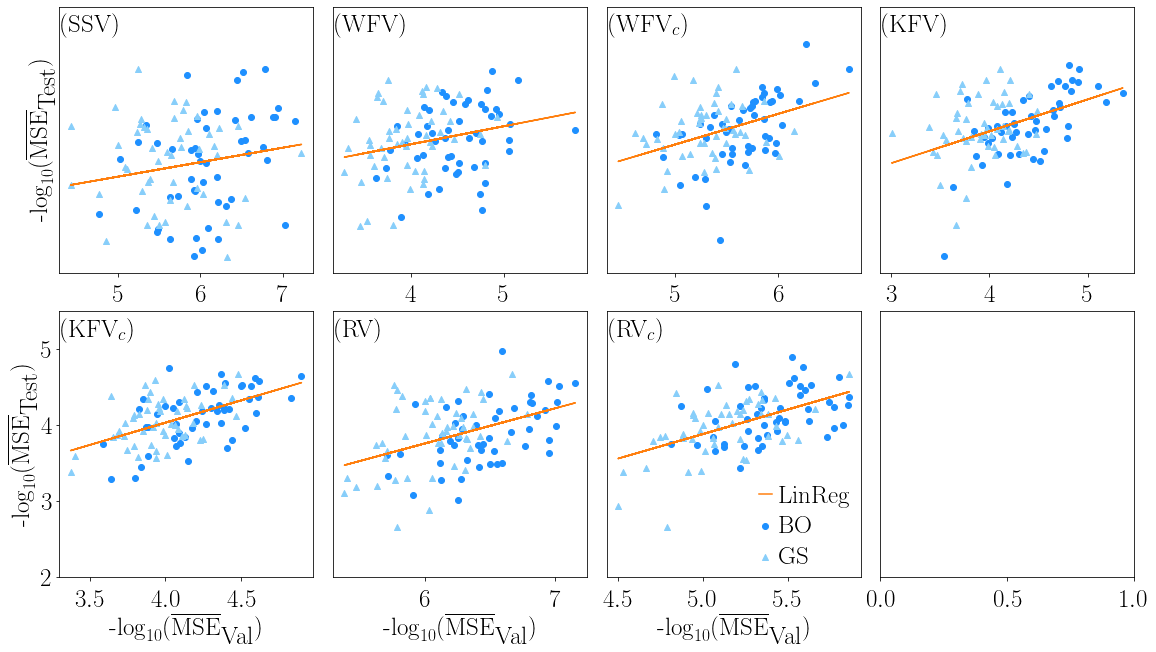

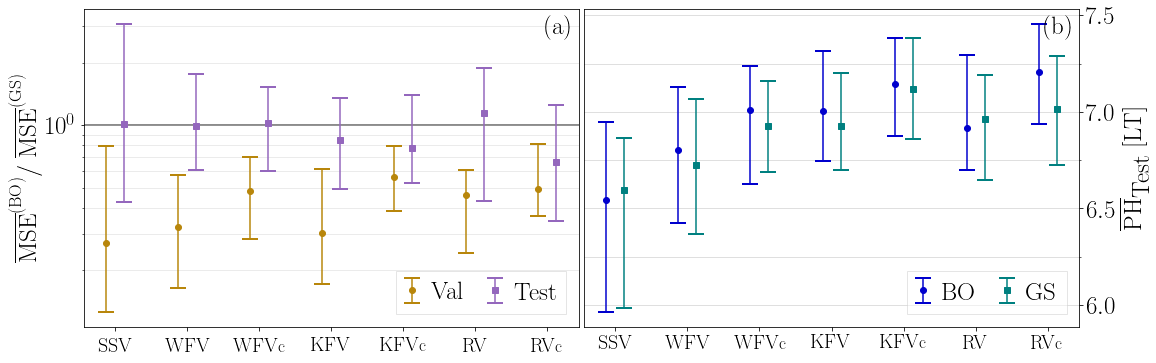

In [19]:
## plot scatter plots and error bars identical to the ones used in model-free
scatter(2,5.5)
err_bars()